# DTSA-5509 SUPERVISED LEARNING FINAL
# BY- KEITH S.

Abstract:

For this project I will work with the '1985 Auto Imports Database'. The goal for this project is to create and compare different regression models. The models will be using the '1985 Auto Imports Database' to predict the price of a new car. I will be comparing 3 different techniques linear regression, gradiant boosting regression, and tree regression. I will be splitting the data into train and test sets. The train data will be used to initialize and fine tune each model. I will be using RMSE to evaluate the final models on the test data at the end.  

Dataset:

Dataset is the '1985 Auto Imports Database' it consists of 3 parts. 1. Car and truck specifications from 1985 wards automotive yearbook. 2. A numeric scale of relative insurance risk from -3 to +3 called 'symboling'. And 3. normalized losses as compared to other vehicles. Dataset has 26 unique features with a mixture of catagorical and continuous variables.  

Data set is from https://www.kaggle.com/datasets/toramky/automobile-dataset  

This report will be broken up into the following sections. 

1. EDA

    1.1 Import Data    
    1.2 Explore Data    
    1.3 NULL characters    
    1.4 Clean     
    1.5 Visualizations

2. Linear Regression Model
    
    2.1 Preprocess data    
    2.2 Single feature model    
    2.3 Full feature model  
    2.4 Reduced feature model    
    2.5 Analysis

3. GradiantBoost Model

    3.1 Preprocess data    
    3.2 Build Model   
    3.3 Tune Hyperparameters   
    3.4 Analysis    
    
4. Tree Regression Model
    
    4.1 Build Model   
    4.2 Tune Hyperparameters    
    4.3 Analysis    
    
5. Conclusion

    5.1 Model Test Results   
    5.2 Last Remarks    


In [49]:
# import necessary libraries

import numpy as np 
import pandas as pd 
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/automobile-dataset/Automobile_data.csv


In [50]:
# helper function for predictions
def prediction(x, y , model):
    pred = model.predict(x)
    RSS = np.sum(np.square(y.to_numpy() - pred))
    SSE = np.sum(np.square(y.to_numpy() - pred.mean()))
    SST = RSS + SSE
    r2 = 1 - (RSS/SST)
    rmse = np.sqrt(mean_squared_error(y, pred))
    
    return r2 , rmse

# 1
# EDA

In [51]:
# 1.1
# import dataset into data frame 

df = pd.read_csv('/kaggle/input/automobile-dataset/Automobile_data.csv')

In [52]:
# 1.2
# Explore Dataset look for any obvious anamolies

print(df.head())
print(df.info())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...  engine-size  \
0  convertible          rwd           front        88.6  ...          130   
1  convertible          rwd           front        88.6  ...          130   
2    hatchback          rwd           front        94.5  ...          152   
3        sedan          fwd           front        99.8  ...          109   
4        sedan          4wd           front        99.4  ...          136   

   fuel-system  bore  stroke compression-ratio hor

Looking at the general overview of our data I can see we have 26 features. 16 of those features are of type object which may need to be converted into int64 or dummy variables. I also see several entries with '?' instead of values and see 0 null entries. The '?' might be used as null type value.  

In [53]:
# 1.3 
# lets count string nulls 

# List of string type Nulls
nogo = ['NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
# this loop is from previous assignment from week 1
for c in df.columns:
    string_null = np.array([x in nogo[2:] for x in df[c]])
    print(c, string_null.sum())
    


symboling 0
normalized-losses 41
make 0
fuel-type 0
aspiration 0
num-of-doors 2
body-style 0
drive-wheels 0
engine-location 0
wheel-base 0
length 0
width 0
height 0
curb-weight 0
engine-type 0
num-of-cylinders 0
engine-size 0
fuel-system 0
bore 4
stroke 4
compression-ratio 0
horsepower 2
peak-rpm 2
city-mpg 0
highway-mpg 0
price 4


Searching for string type nulls we can see we have 41 entries in normalized-losses and 6 columns with 4 or fewer. 

In [54]:
# 1.4
# Lets clean up our string null values 
def clean_me(df_temp):
    # First lets take care of our Normalized-losses column 
    # we will convert '?' to 0 and calculate the mean value and replace
    df_temp['normalized-losses'] = df_temp['normalized-losses'].replace('?',0)
    df_temp['normalized-losses'] = pd.to_numeric(df_temp['normalized-losses'])
    norm_mean = df['normalized-losses'].mean()
    print('Average normalized losses is',norm_mean)
    df_temp['normalized-losses'] = df['normalized-losses'].replace(0,norm_mean)
    print(df_temp['normalized-losses'])

    # now we will just remove all other rows with '?'
    df_temp = df_temp.loc[(df!='?').all(axis=1)]
    
    # lets change object to numeric where possible
    col_list = ['bore','stroke','horsepower','price','peak-rpm']
    
    for col in col_list:
        df_temp[col] = df_temp[col].astype('float')
    # rename non usable column names
    df_temp.rename(columns = {'engine-size':'EngineSize','wheel-base':'WheelBase',
                              'curb-weight':'CurbWeight','highway-mpg':'HighwayMpg','city-mpg':'CityMpg' ,
                              'fuel-type':'FuelType', 'num-of-doors':'NumDoors' , 'body-style':'BodyStyle' ,
                              'drive-wheels':'DriveWheels', 'engine-location':'EngineLocation' , 
                              'engine-type': 'EngineType' , 'num-of-cylinders':'NumCylinders' , 
                              'fuel-system':'FuelSystem' , 'compression-ratio':'CompressionRatio' }, inplace = True)
    return df_temp

df = clean_me(df)

Average normalized losses is 97.6
0       97.6
1       97.6
2       97.6
3      164.0
4      164.0
       ...  
200     95.0
201     95.0
202     95.0
203     95.0
204     95.0
Name: normalized-losses, Length: 205, dtype: float64


/tmp/ipykernel_32/2591880935.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[col] = df_temp[col].astype('float')
/tmp/ipykernel_32/2591880935.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns = {'engine-size':'EngineSize','wheel-base':'WheelBase',


**Now our data is cleaned and ready for further analysis. Lets look at our data a little closer with some visualizations**


/tmp/ipykernel_32/2713150438.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

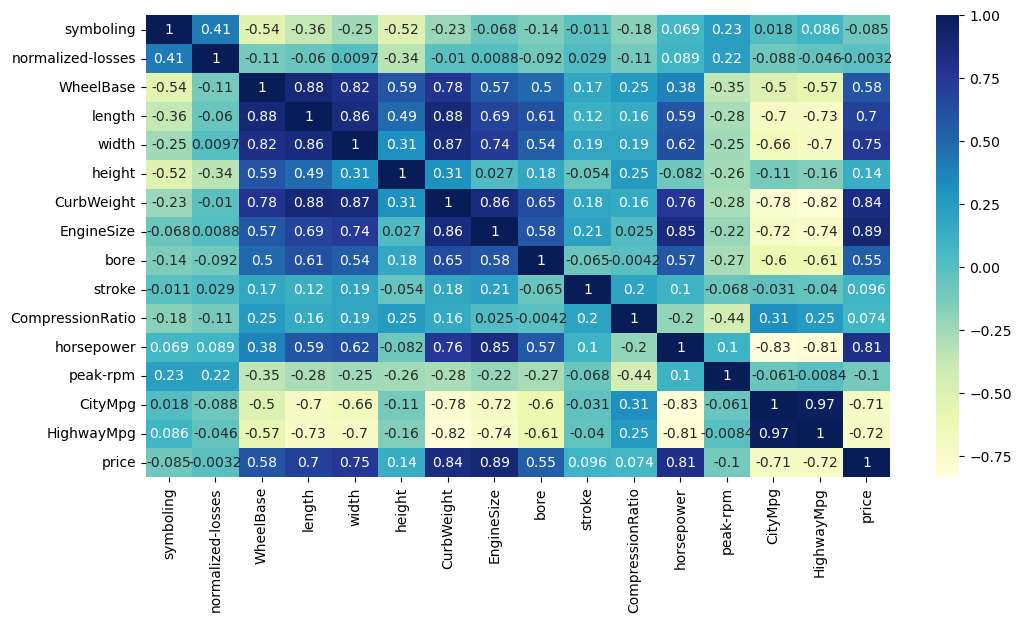

In [55]:
# 1.5 Visualization
# Lets take a closer look at the relationships between our features and vehicle price

# Correlation Matrix
corr = df.corr()
fig, ax = pyplot.subplots(figsize=(12,6))
sns.heatmap(corr, cmap="YlGnBu", annot=True, ax = ax)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 204
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            193 non-null    object 
 1   FuelType        193 non-null    object 
 2   aspiration      193 non-null    object 
 3   NumDoors        193 non-null    object 
 4   BodyStyle       193 non-null    object 
 5   DriveWheels     193 non-null    object 
 6   EngineLocation  193 non-null    object 
 7   WheelBase       193 non-null    float64
 8   length          193 non-null    float64
 9   width           193 non-null    float64
 10  CurbWeight      193 non-null    int64  
 11  EngineType      193 non-null    object 
 12  NumCylinders    193 non-null    object 
 13  EngineSize      193 non-null    int64  
 14  FuelSystem      193 non-null    object 
 15  bore            193 non-null    float64
 16  horsepower      193 non-null    float64
 17  CityMpg         193 non-null    int

/tmp/ipykernel_32/2717137837.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = price_df.corr()
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


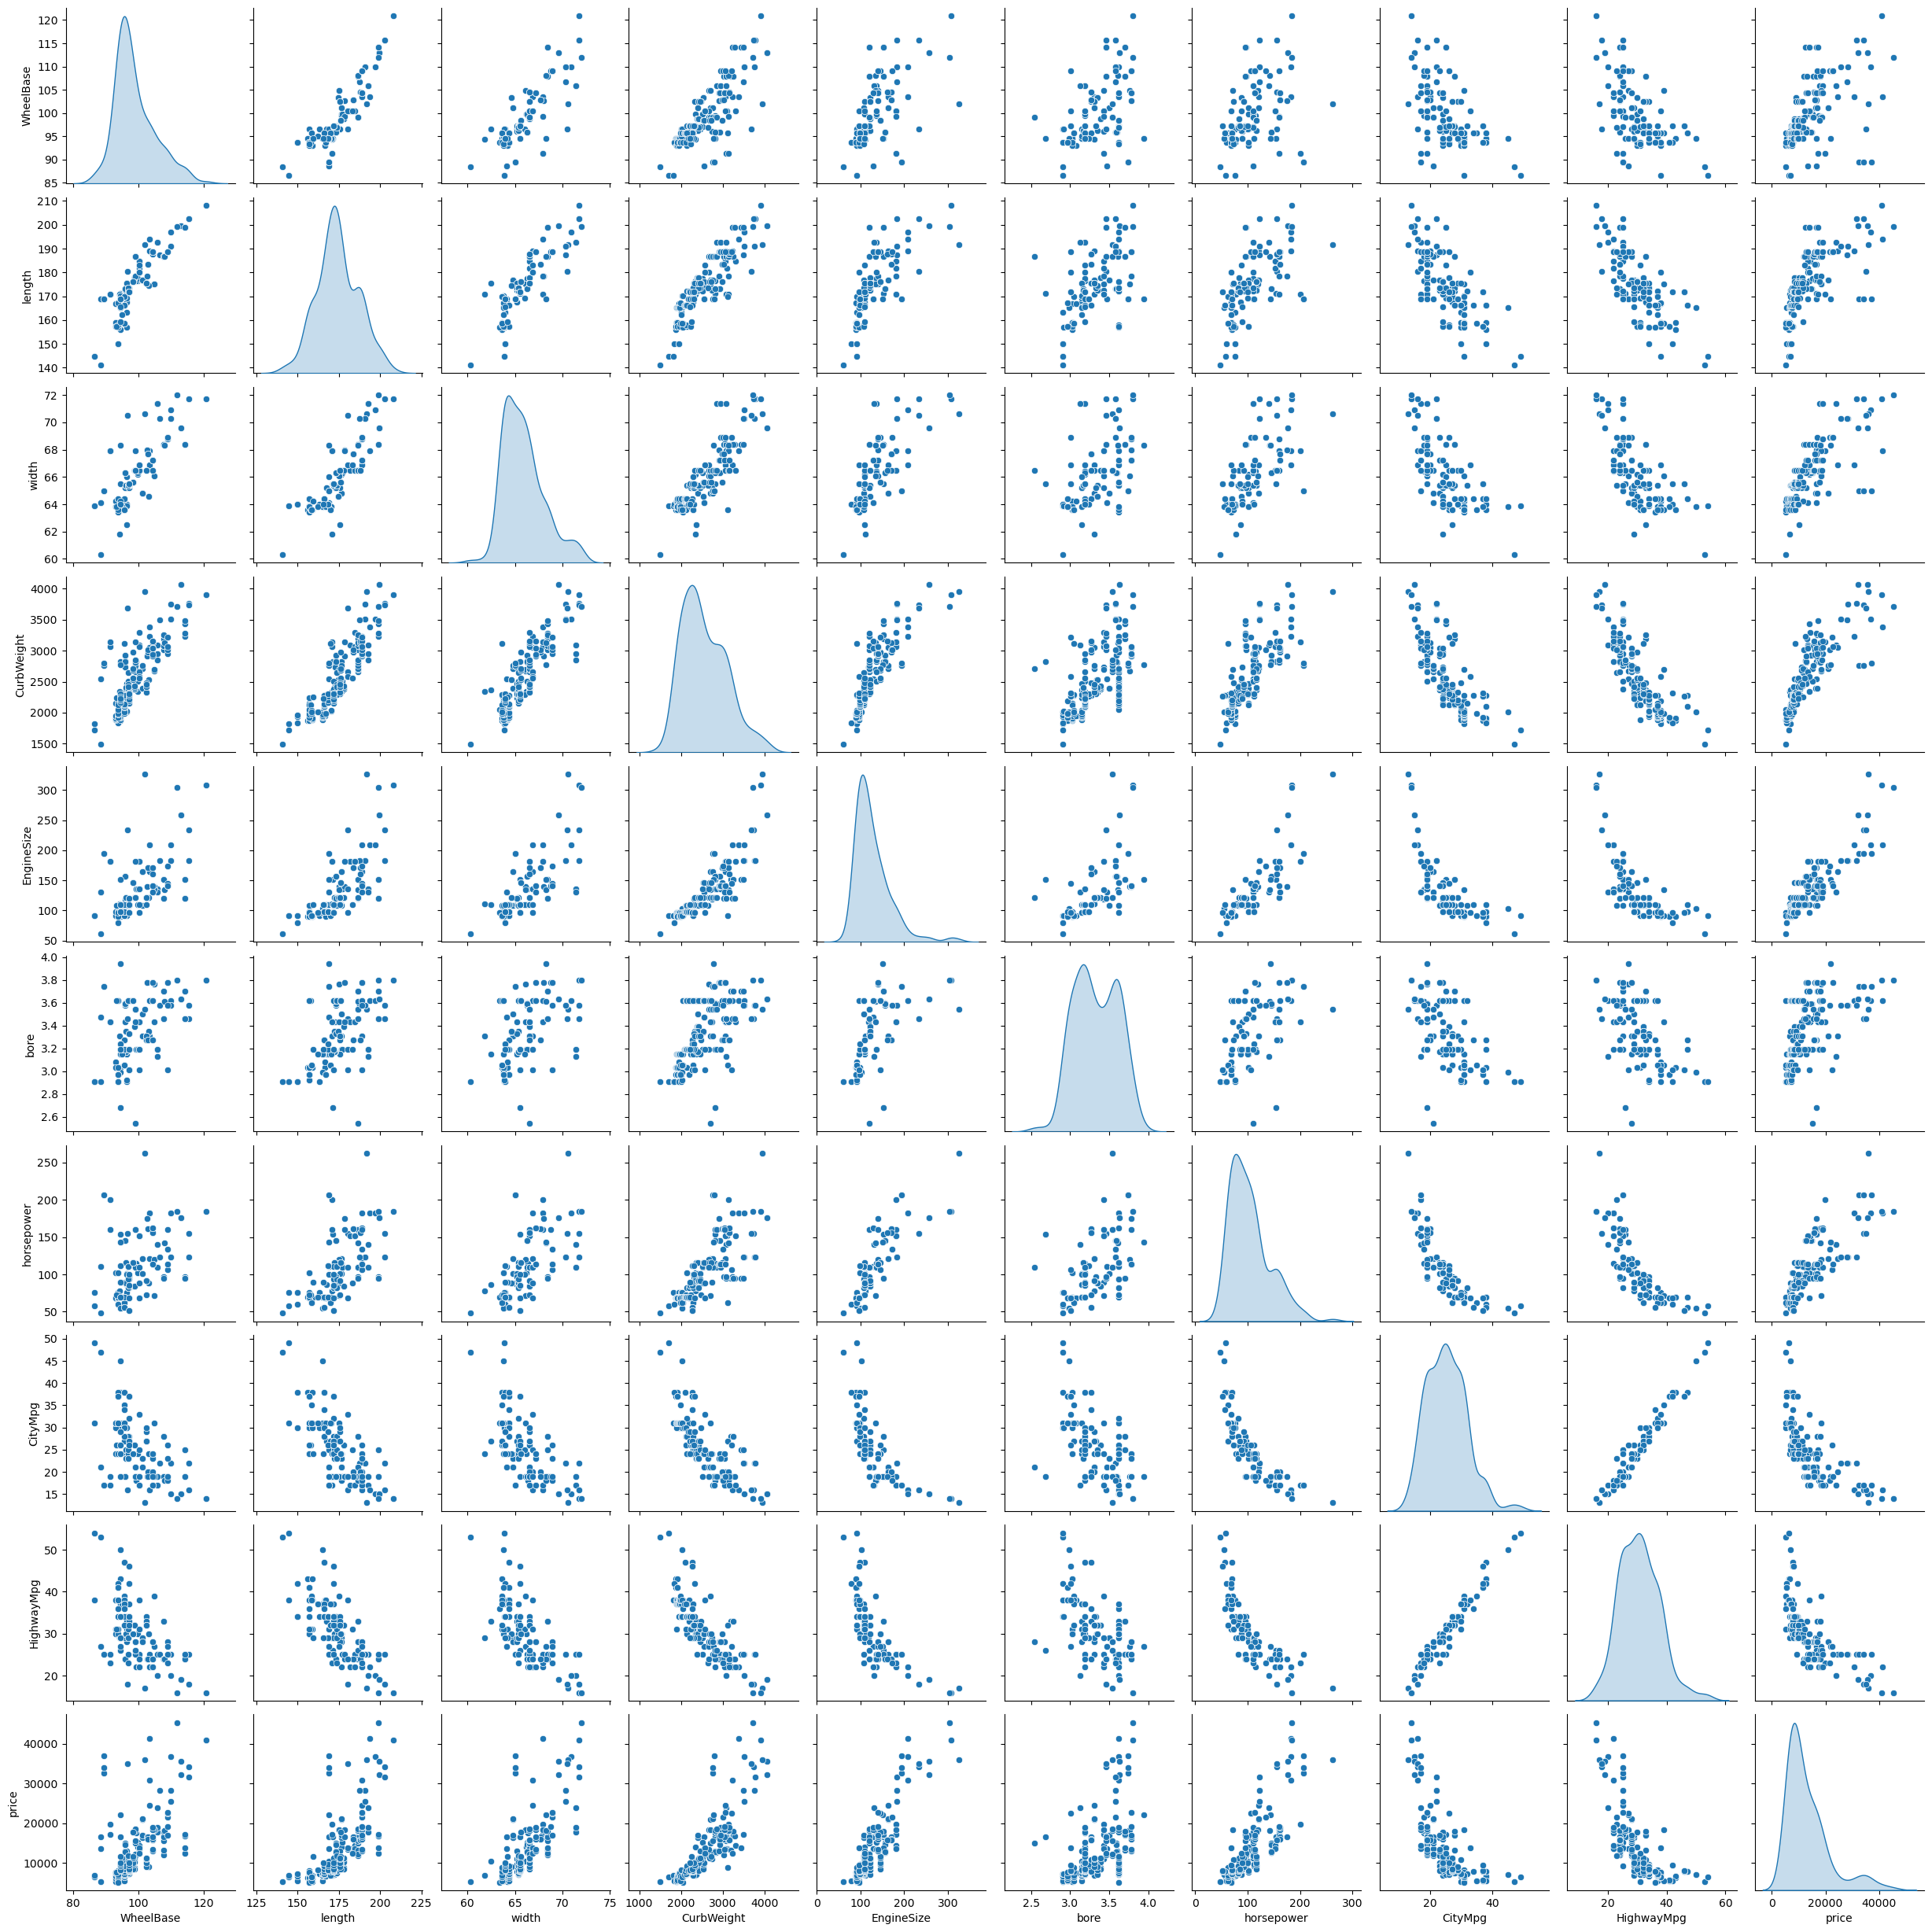

In [56]:
# Pair plot with reduced DF

# lets drop any low/non correlated features

price_df = df.drop(['peak-rpm','CompressionRatio','stroke','height','normalized-losses','symboling'],axis = 1)
price_df.info()

corr = price_df.corr()
sns.pairplot(price_df, diag_kind = 'kde')

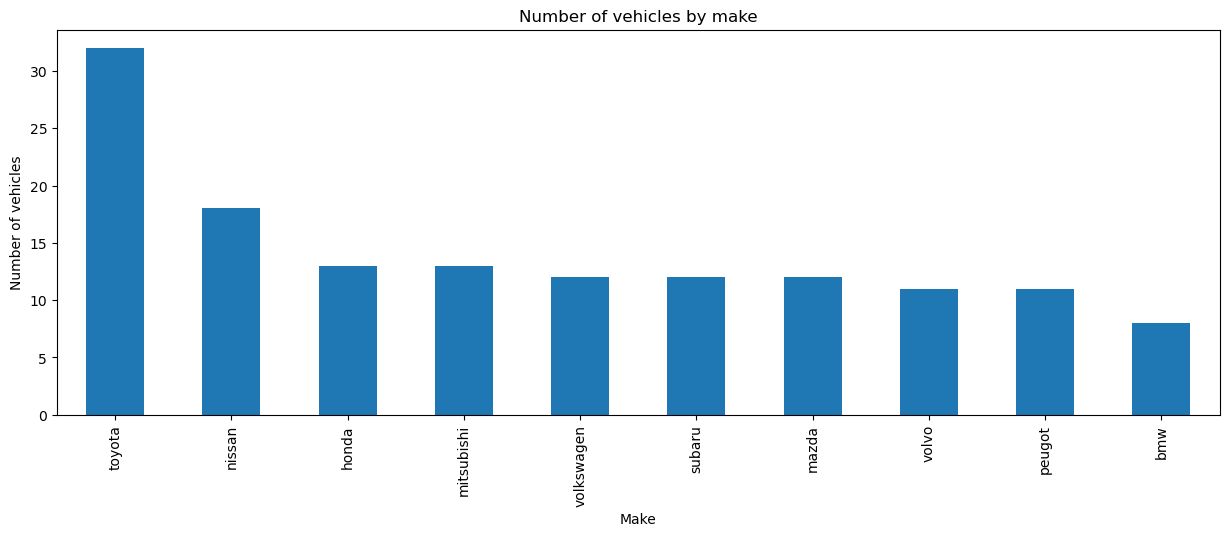

In [26]:
# lets plot number of vehicles by make

df.make.value_counts().nlargest(10).plot(kind='bar', figsize=(15,5))
plt.title("Number of vehicles by make")
plt.ylabel('Number of vehicles')
plt.xlabel('Make');

<Axes: xlabel='price', ylabel='horsepower'>

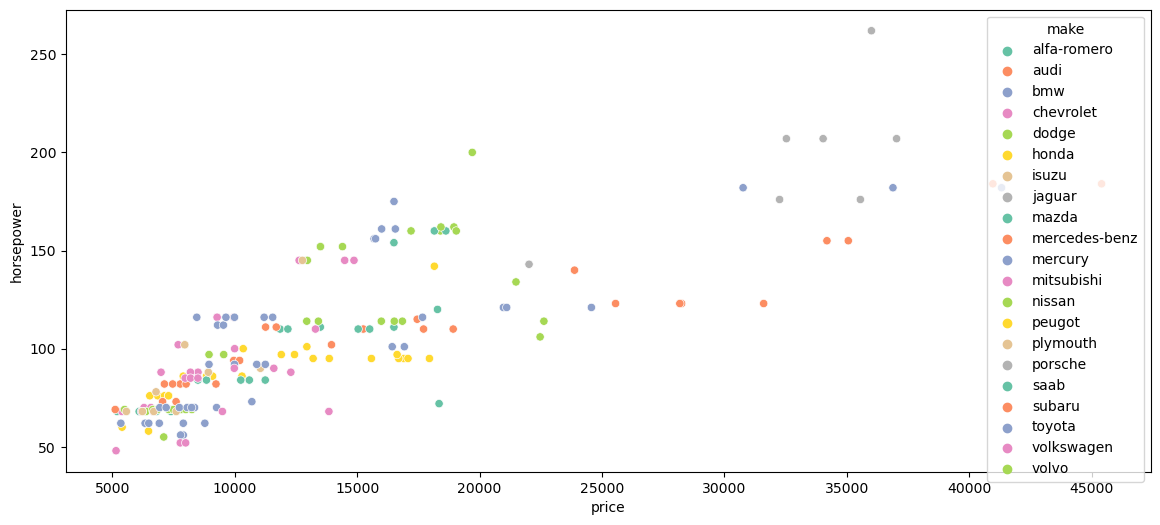

In [37]:
# lets plot number of vehicles by make
fig, ax = pyplot.subplots(figsize=(14,6))
sns.scatterplot(data=df, x="price", y="horsepower", hue="make", ax = ax, palette="Set2")

<Axes: xlabel='EngineSize', ylabel='horsepower'>

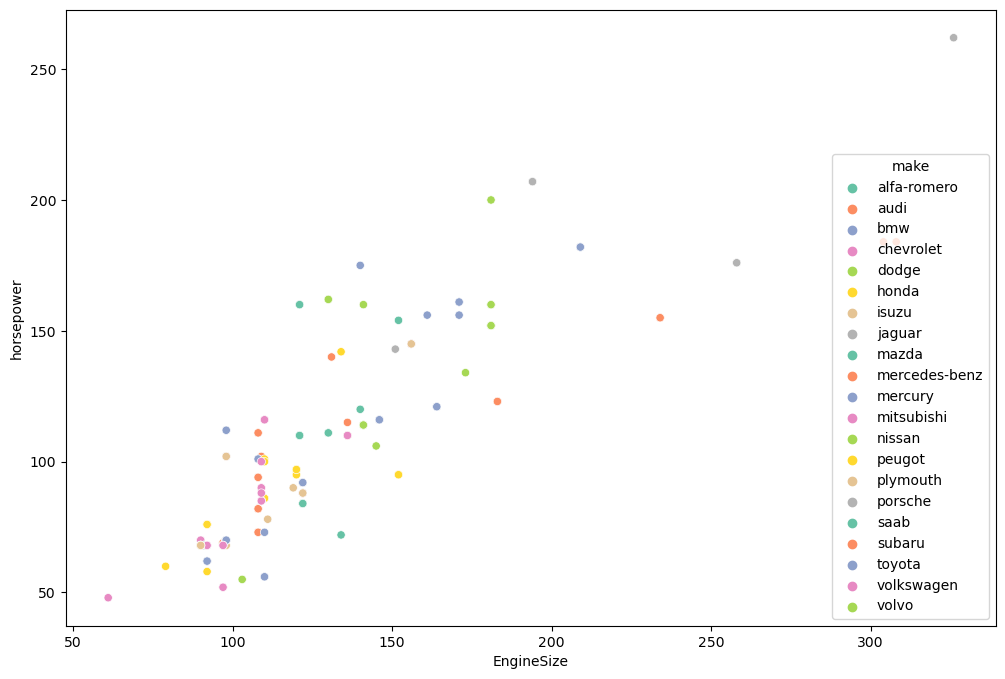

In [40]:
fig, ax = pyplot.subplots(figsize=(12,8))
sns.scatterplot(data=df, x="EngineSize", y="horsepower", hue="make", ax = ax, palette="Set2")

# 2
# Linear Regression

**Now lets move on to our first model. I want to try and predict the price of a vehicle based on the other features. I want to first explore our data a little further and see what sort of relationships with price show up. Then we will move onto constructing and fitting our model. Then we will finetune the model. Last we will discuss our results.**  

In [57]:
# 2.1 Split
# lets split our data into test and train

X_train , X_test = train_test_split(price_df, random_state=42, test_size=0.25, shuffle=True)
X_train.info()

X_test['make'] = X_test['make'].replace('mercury','nissan')
X_test['NumCylinders'] = X_test['NumCylinders'].replace('twelve','three')
X_test['FuelSystem'] = X_test['FuelSystem'].replace('spfi','mfi')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 138 to 111
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            144 non-null    object 
 1   FuelType        144 non-null    object 
 2   aspiration      144 non-null    object 
 3   NumDoors        144 non-null    object 
 4   BodyStyle       144 non-null    object 
 5   DriveWheels     144 non-null    object 
 6   EngineLocation  144 non-null    object 
 7   WheelBase       144 non-null    float64
 8   length          144 non-null    float64
 9   width           144 non-null    float64
 10  CurbWeight      144 non-null    int64  
 11  EngineType      144 non-null    object 
 12  NumCylinders    144 non-null    object 
 13  EngineSize      144 non-null    int64  
 14  FuelSystem      144 non-null    object 
 15  bore            144 non-null    float64
 16  horsepower      144 non-null    float64
 17  CityMpg         144 non-null    i

In [58]:
# 2.2 Build
# lets try a simple linear model using only the most correlated value EngineSize
mod_simple = smf.ols(formula = 'price ~ EngineSize ', data = X_train)

res_simple = mod_simple.fit()
print(res_simple.summary())  
    

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     508.0
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           9.42e-49
Time:                        14:37:09   Log-Likelihood:                -1378.7
No. Observations:                 144   AIC:                             2761.
Df Residuals:                     142   BIC:                             2767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8665.1482   1020.715     -8.489      0.0

In [59]:
# 2.3 Full model
r_sq1 = []
aic1 = []
features = list(X_train.columns)
del features[-1]
formula_next = 'price ~ '
count = 0
cnt = []
for feat in features:
    count = count + 1
    cnt.append(count)
    formula_next = formula_next + '+' + feat  
    mod_full = smf.ols(formula = formula_next, data = X_train)
    res_full = mod_full.fit()
    r_sq1.append(res_full.rsquared_adj)
    aic1.append(res_full.aic)
    
print(res_full.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     76.38
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           7.65e-59
Time:                        14:37:12   Log-Likelihood:                -1225.6
No. Observations:                 144   AIC:                             2547.
Df Residuals:                      96   BIC:                             2690.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.40

In [60]:
#2.4
# reduced model using backward selection
r_sq = []
aic = []
mod_red = smf.ols(formula = 'price ~ make+FuelType+aspiration+NumDoors+BodyStyle+DriveWheels+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+NumCylinders+EngineSize+FuelSystem+bore+CityMpg+HighwayMpg', data = X_train)
res_red = mod_red.fit()
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make+FuelType+aspiration+NumDoors+BodyStyle+DriveWheels+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+NumCylinders+EngineSize+bore+CityMpg+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make+FuelType+aspiration+NumDoors+BodyStyle+DriveWheels+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+NumCylinders+EngineSize+bore+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

# lets remove drive wheels and replace with RWD only column
temp_lst = []
for i,data in enumerate(X_train["DriveWheels"]):
    if data == 'rwd' :
        temp_lst.append(1)
    else:
        temp_lst.append(0)
X_train["rwd"] = temp_lst

temp_lst = []
for i,data in enumerate(X_test["DriveWheels"]):
    if data == 'rwd' :
        temp_lst.append(1)
    else:
        temp_lst.append(0)
X_test["rwd"] = temp_lst

mod_red = smf.ols(formula = 'price ~ make+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+NumCylinders+EngineSize+bore+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

# lets remove Number of cylinders and only include 4, 5, and 6
temp_lst = []
for i,data in enumerate(X_train["NumCylinders"]):
    if data == 'four' :
        temp_lst.append(1)
    elif data == 'five':
        temp_lst.append(2)
    elif data == 'six':
        temp_lst.append(3)
    else:
        temp_lst.append(0)
        
X_train["cyl"] = temp_lst

temp_lst = []
for i,data in enumerate(X_test["NumCylinders"]):
    if data == 'four' :
        temp_lst.append(1)
    elif data == 'five':
        temp_lst.append(2)
    elif data == 'six':
        temp_lst.append(3)
    else:
        temp_lst.append(0)
        
X_test["cyl"] = temp_lst

mod_red = smf.ols(formula = 'price ~ make+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+cyl+EngineSize+bore+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)


# lets remove all makes that with high p-values
temp_lst = []
for i,data in enumerate(X_train["make"]):
    #print(data)
    if data == 'mazda' :
        temp_lst.append(0)
    elif data == 'honda':
        temp_lst.append(0)
    elif data == 'nissan':
        temp_lst.append(0)
    elif data == 'volkswagen':
        temp_lst.append(0)
    elif data == 'volvo':
        temp_lst.append(0)
    elif data == 'alfa-romero':
        temp_lst.append(0)
    elif data == 'chevrolet':
        temp_lst.append(0)
    elif data == 'plymouth':
        temp_lst.append(0)
    else:
        #print(data)
        temp_lst.append(data)
        
X_train["make_c"] = temp_lst

temp_lst = []
for i,data in enumerate(X_test["make"]):
    #print(data)
    if data == 'mazda' :
        temp_lst.append(0)
    elif data == 'honda':
        temp_lst.append(0)
    elif data == 'nissan':
        temp_lst.append(0)
    elif data == 'volkswagen':
        temp_lst.append(0)
    elif data == 'volvo':
        temp_lst.append(0)
    elif data == 'alfa-romero':
        temp_lst.append(0)
    elif data == 'chevrolet':
        temp_lst.append(0)
    elif data == 'plymouth':
        temp_lst.append(0)
    else:
        #print(data)
        temp_lst.append(data)
        
X_test["make_c"] = temp_lst

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+width+CurbWeight+EngineType+cyl+EngineSize+bore+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

# lets remove all engine types except for ohcf
temp_lst = []
for i,data in enumerate(X_train["EngineType"]):
    if data == 'ohcf' :
        temp_lst.append(1)
    else:
        temp_lst.append(0)
X_train["ET"] = temp_lst

temp_lst = []
for i,data in enumerate(X_test["EngineType"]):
    if data == 'ohcf' :
        temp_lst.append(1)
    else:
        temp_lst.append(0)
X_test["ET"] = temp_lst

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+width+CurbWeight+ET+cyl+EngineSize+bore+HighwayMpg', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())
r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+width+CurbWeight+ET+cyl+EngineSize+bore', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())

r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+NumDoors+BodyStyle+rwd+EngineLocation+WheelBase+length+CurbWeight+ET+cyl+EngineSize+bore', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())

r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+NumDoors+rwd+BodyStyle+EngineLocation+WheelBase+CurbWeight+ET+cyl+EngineSize+bore', data = X_train)
res_red = mod_red.fit()
#print(res_red.summary())

r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

mod_red = smf.ols(formula = 'price ~ make_c+FuelType+aspiration+rwd+BodyStyle+EngineLocation+WheelBase+CurbWeight+ET+cyl+EngineSize+bore', data = X_train)
res_red = mod_red.fit()
print(res_red.summary())

r_sq.append(res_red.rsquared_adj)
aic.append(res_red.aic)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     136.9
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           2.52e-75
Time:                        14:37:17   Log-Likelihood:                -1243.3
No. Observations:                 144   AIC:                             2539.
Df Residuals:                     118   BIC:                             2616.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

Simple linear model with single feature. R-Squared =  0.7799964576609126 AIC =  2761.3580657779385
Full feature linear model with 18 features. R-Squared =  0.961201001796342 AIC =  2547.10922123627
Reduced linear model with 12 features. R-Squared =  0.9596153490624126 AIC =  2538.5896392388076


<Axes: xlabel='FeatureCount', ylabel='Adj_R_Squared'>

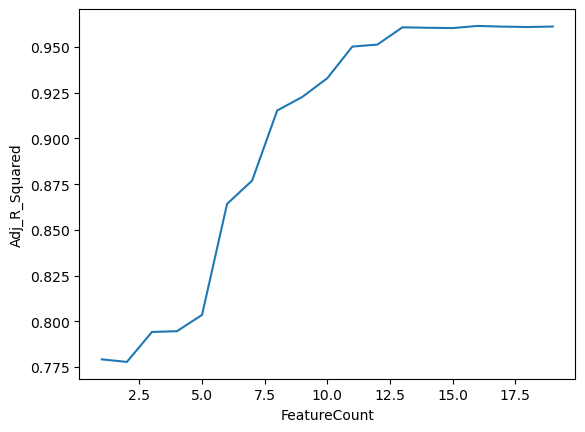

In [61]:
# 2.5 Analysis  

print('Simple linear model with single feature. R-Squared = ', res_simple.rsquared_adj, 'AIC = ', res_simple.aic)
print('Full feature linear model with 18 features. R-Squared = ', res_full.rsquared_adj, 'AIC = ', res_full.aic)
print('Reduced linear model with 12 features. R-Squared = ', res_red.rsquared_adj, 'AIC = ', res_red.aic)

# AIC and R2 vs # of features

vis_df = pd.DataFrame({'FeatureCount': cnt , 'Adj_R_Squared': r_sq1 , 'AIC': aic1}) 

sns.lineplot(data = vis_df , y = 'Adj_R_Squared' , x = 'FeatureCount')

#sns.lineplot(data = vis_df , y = 'AIC' , x = 'FeatureCount')

<Axes: xlabel='FeatureCount', ylabel='AIC'>

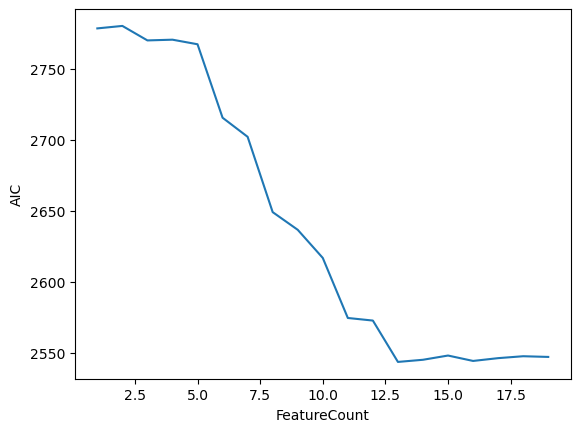

In [13]:
sns.lineplot(data = vis_df , y = 'AIC' , x = 'FeatureCount')

In [66]:
# model results

r2_LM_train , rmse_LM_train = prediction(X_train, y_train, res_red)

print(r2_LM_train)
print(rmse_LM_train)

r2_LM_test , rmse_LM_test = prediction(X_test, y_test, res_red)

0.9677503043913602
1359.7460994332478


# 3
# Gradiant Boosted Model

**Next i want to try a gradiant boosted model. We first need to process our data a little bit and remove categorical variables before constructing the model.** 

In [67]:
# 3.1
# lets try an alternative model with gradient boosting 
# for gradient boosting we need to convert all categorical variables to dummy numeric values
le = LabelEncoder()
col_list = ['make','FuelType','aspiration','NumDoors','BodyStyle','DriveWheels','EngineLocation','EngineType','NumCylinders','FuelSystem']
for obj in col_list:
    price_df[obj] = le.fit_transform(price_df[obj])


# lets split data frame for our alternative model
y = price_df.pop('price')
X_train , X_test , y_train , y_test = train_test_split(price_df, y, random_state=42, test_size=0.25, shuffle=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 138 to 111
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            144 non-null    int64  
 1   FuelType        144 non-null    int64  
 2   aspiration      144 non-null    int64  
 3   NumDoors        144 non-null    int64  
 4   BodyStyle       144 non-null    int64  
 5   DriveWheels     144 non-null    int64  
 6   EngineLocation  144 non-null    int64  
 7   WheelBase       144 non-null    float64
 8   length          144 non-null    float64
 9   width           144 non-null    float64
 10  CurbWeight      144 non-null    int64  
 11  EngineType      144 non-null    int64  
 12  NumCylinders    144 non-null    int64  
 13  EngineSize      144 non-null    int64  
 14  FuelSystem      144 non-null    int64  
 15  bore            144 non-null    float64
 16  horsepower      144 non-null    float64
 17  CityMpg         144 non-null    i

In [69]:
# 3.2
# lets initialize and fit our model
def boost_me(X , y , n = 25, rate = 1.0, depth = 1):
    boosted = GradientBoostingRegressor(n_estimators=n, learning_rate=rate, max_depth = depth, random_state=0).fit(X,y)
    
    return boosted

boost_mod = boost_me(X_train, y_train)
boost_r2 , boost_rmse = prediction(X_train, y_train, boost_mod )
print(boost_r2)
print(boost_rmse)

0.9638784012073139
1441.9461041793554


In [71]:
# 3.3
# lets fine tune our hyperparameters
r2 = []
r2_best = 0
rmse = []
rmse_best = 10000
n = [1,5,10,15,20,25,30,35,40,50,75,100]
rate = np.arange(0.1,1.5, .15)
deep = [1,2,3]
n_count = []
rate_count = []
deep_count = []
param_best = {}
for i in n:
    for r in rate:
        for d in deep:
            temp = boost_me(X_train, y_train, n = i, rate = r, depth = d)
            r2_temp , rmse_temp = prediction(X_train, y_train, temp)
            r2.append(r2_temp)
            rmse.append(rmse_temp)
            n_count.append(i)
            rate_count.append(r)
            deep_count.append(d)
        
            if r2_temp > r2_best and rmse_temp < rmse_best:
                r2_best = r2_temp
                rmse_best = rmse_temp
                param_best['n'] = i
                param_best['depth'] = d
                param_best['rate'] = r


print(param_best)
print(r2_best)
print(rmse_best)

{'n': 100, 'depth': 3, 'rate': 0.9999999999999999}
0.998303904281629
307.02268411013125


In [75]:
# 3.4
# analysis
full_boost = boost_me(X_train, y_train, n = param_best['n'], rate = param_best['rate'], depth = param_best['depth'])
r2_boost_train , rmse_boost_train = prediction(X_train, y_train, full_boost)
r2_boost_test , rmse_boost_test = prediction(X_test, y_test, full_boost)
print(r2_boost_train)
print(rmse_boost_train)


0.998303904281629
307.02268411013125


<Axes: xlabel='N_count', ylabel='R_Squared'>

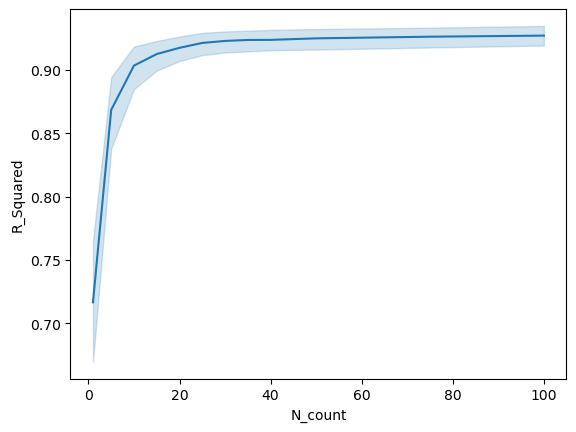

In [20]:
vis_df = pd.DataFrame({'N_count': n_count , 'R_Squared': r2 , 'Rate': rate_count , 'Depth': deep_count}) 
sns.lineplot(data = vis_df , y = 'R_Squared' , x = 'N_count')

# 4
# Tree Regression Model

In [21]:
# 4.1
# lets initialize and fit our model
def tree_me(X , y , n = 'squared_error', split = 'best', max_f = None):
    tree_mod = DecisionTreeRegressor(criterion=n, splitter=split, max_features = max_f, random_state=0).fit(X,y)
    
    return tree_mod

tree_mod = tree_me(X_train, y_train)

In [76]:
tree_r2_train , tree_rmse_train = prediction(X_train, y_train, tree_mod )
print(tree_r2)
print(tree_rmse)

0.9983039166574943
307.0215620821009


In [78]:
# 4.2
# tuning hyperparameters
r2 = []
r2_best = 0
rmse = []
rmse_best = 10000
crit = ['squared_error','friedman_mse','absolute_error','poisson']
split = ['best','random']
max_f = [1.0,'sqrt','log2',None]
n_count = []
rate_count = []
deep_count = []
param_best = {}
for i in crit:
    for r in split:
        for d in max_f:
            temp = tree_me(X_train, y_train, n = i, split = r, max_f = d)
            r2_temp , rmse_temp = prediction(X_train, y_train, temp)
            r2.append(r2_temp)
            rmse.append(rmse_temp)
            n_count.append(i)
            rate_count.append(r)
            deep_count.append(d)
        
            if r2_temp > r2_best and rmse_temp < rmse_best:
                r2_best = r2_temp
                rmse_best = rmse_temp
                param_best['criterion'] = i
                param_best['max_f'] = d
                param_best['split'] = r


print(param_best)
print(r2_best)
print(rmse_best)

{'criterion': 'squared_error', 'max_f': 1.0, 'split': 'best'}
0.9983039166574943
307.0215620821009


In [81]:
# 4.3
# analysis
full_tree = tree_me(X_train, y_train, n = param_best['criterion'], split = param_best['split'], max_f = param_best['max_f'])
r2_tree_train , rmse_tree_train = prediction(X_train, y_train, full_tree)
r2_tree_test , rmse_tree_test = prediction(X_test, y_test, full_tree)
print(r2_tree_train)
print(rmse_tree_train)


0.9983039166574943
307.0215620821009


# 5
# Conclusion


In [86]:
# 5.1
# test results

print('Reduced linear model on the train data had a R_squared of',r2_LM_train ,'and an RMSE of' ,rmse_LM_train)
print('Reduced linear model on the test data had a R_squared of',r2_LM_test ,'and an RMSE of' ,rmse_LM_test)

print('Gradiant Boosted model on the train data had a R_squared of',r2_boost_train ,'and an RMSE of' ,rmse_boost_train)
print('Gradiant Boosted model on the test data had a R_squared of',r2_boost_test ,'and an RMSE of' ,rmse_boost_test)

print('Tree Regression model on the train data had a R_squared of',r2_tree_train ,'and an RMSE of' ,rmse_tree_train)
print('Tree Regression model on the test data had a R_squared of',r2_tree_test ,'and an RMSE of' ,rmse_tree_test)

Reduced linear model on the train data had a R_squared of 0.9677503043913602 and an RMSE of 1359.7460994332478
Reduced linear model on the test data had a R_squared of 0.9028566264531537 and an RMSE of 3167.409487242151
Gradiant Boosted model on the train data had a R_squared of 0.998303904281629 and an RMSE of 307.02268411013125
Gradiant Boosted model on the test data had a R_squared of 0.9004433494131776 and an RMSE of 3217.9565863385774
Tree Regression model on the train data had a R_squared of 0.9983039166574943 and an RMSE of 307.0215620821009
Tree Regression model on the test data had a R_squared of 0.9008214971692263 and an RMSE of 3210.01866054084


**5.2**

**The goal of this project was to compare different regression techniques on predicting the price of a new car based on the features of the car. 3 regression models were created and ran on the same dataset. The models were evaluated using RMSE on the test set.** 

**The first was a linear regression model that was optimized using backwords feature selection. The model achieved a RMSE of 1359 on the training data and 3167 on the test data. The second model was a gradiant boosted regression model which achieved a RMSE of 307 on the train data and 3217 on the test data. And last was a tree regression model which achieved a RMSE of 307 on the train data and 3210 on the test data.** 

**As for difficulty in implementing the linear regression took quit a bit of manual tuning and data manipulation to achieve the final model. The gradiant boosted and tree regression models were mostly hands off once code was written and hyperparameters were tuned automatically.** 

**The linear regression model achieved the worst training score but the best test score. The other 2 models achieved relatively similar scores with the test scores being significantly worse than the training scores. This tells me that those 2 models might be overfit and need more adjusting to be as good or better than the linear regression model.**